In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [3]:
from matplotlib.patches import Ellipse
def plot_2d_normal_densities(mu, var, plot_standard=False):
    fig = plt.figure(0)
    ax = fig.add_subplot(111, aspect='equal')

    if plot_standard:
        e = Ellipse([0,0], 6, 6, edgecolor='black')
        e.set_alpha(0.5)
        e.set_facecolor([1,1,1])
        ax.add_artist(e)#fig.add_artist(e)

    n = len(mu)
    max_x = 0
    min_x = np.inf
    max_y = 0
    min_y = np.inf
    
    for i in range(n):
        e = Ellipse(mu[i], 6*var[i][0], 6*var[i][1])
        e.set_alpha(0.75)
        e.set_facecolor(np.random.rand(3))
        e.set_edgecolor('black')
        ax.add_artist(e)
        
        max_x = max(max_x, mu[i][0]+3*var[i][0])
        min_x = min(min_x, mu[i][0]-3*var[i][0])

        max_y = max(max_y, mu[i][1]+3*var[i][1])
        min_y = min(min_y, mu[i][1]-3*var[i][1])

    ax.set_xlim(min_x-5, max_x+5)
    ax.set_ylim(min_y-5, max_y+5)


### Generate normal data

In [4]:
real_mu = np.array([[0,0], [0, 15], [10, 10]])
real_std = np.array([[1, 1], [0.5, 2], [2, 1]])

In [5]:
num_classes = len(real_mu)

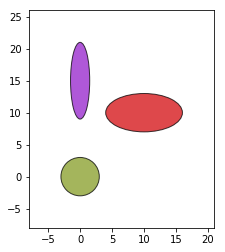

In [6]:
plot_2d_normal_densities(real_mu, real_std)

In [7]:
n_per_class = 3000
class_samples = []
labels = []
for i in range(num_classes):
    x = np.random.multivariate_normal(real_mu[i],
                                      np.diag(real_std[i]**2),
                                      size=n_per_class)
    class_samples.append(x)
    labels.append(np.zeros(n_per_class)+i)
X_train = np.vstack(class_samples)
y_train = np.vstack(labels)

In [8]:
X_train.shape

(9000, 2)

In [9]:
y_train = y_train.reshape(-1)

In [10]:
inds_arr = np.arange(len(X_train))
np.random.shuffle(inds_arr)
X_train = X_train[inds_arr]
y_train = y_train[inds_arr]

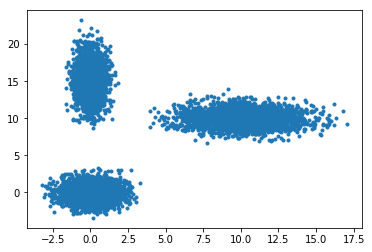

In [11]:
plt.plot(X_train[:,0], X_train[:,1], '.')

## Define model

In [12]:
cuda = torch.cuda.is_available()

In [13]:
cuda

True

In [14]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor   if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor   if use_cuda else torch.ByteTensor
def convert_to_var(arr, astype='float32', add_dim=False):
    if add_dim:
        arr = np.array([arr])
    if astype == 'float32':
        v = Variable(FloatTensor(arr.astype(astype))) 
    else:
        v = Variable(LongTensor(arr.astype(astype)))
    return v

In [15]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [16]:
class VAE(nn.Module):
    def __init__(self, input_shape=(-1, 28*28),
                 latent_dim=2, n_samples=10, fc_size=1024):
        super(VAE, self).__init__()
        self.n_samples = n_samples
        self.input_shape = input_shape
        
        self.encoder = nn.Sequential(
                            nn.Linear(input_shape[-1], fc_size),
                            nn.ReLU(),
                            nn.Dropout(0.2),

                            nn.Linear(fc_size, fc_size//2),
                            nn.ReLU(),
                            nn.Dropout(0.1),
    
                            nn.Linear(fc_size//2, fc_size//4),
                            nn.ReLU(),
                            nn.Dropout(0.1),

                            )
            
        self.fc_mu = nn.Linear(fc_size//4, latent_dim)
        self.fc_logvar = nn.Linear(fc_size//4, latent_dim)
        
        self.decoder = nn.Sequential(
                                nn.Linear(latent_dim, fc_size//4),
                                nn.ReLU(),
                                nn.Dropout(0.2),

                                nn.Linear(fc_size//4, fc_size//2),
                                nn.ReLU(),
                                nn.Dropout(0.1),
            
                                nn.Linear(fc_size//2, fc_size),
                                nn.ReLU(),
                                nn.Dropout(0.1),
        
                                nn.Linear(fc_size, 2*input_shape[1]))

    def encode(self, x):
        enc_out = self.encoder(x)
        return self.fc_mu(enc_out), self.fc_logvar(enc_out)

    def reparameterize(self, mu, logvar):
        if self.training:
            n_samples = self.n_samples
            batch_size = mu.shape[0]
            latent_dim = mu.shape[1]
            eps = np.random.randn(batch_size*latent_dim*n_samples)\
                                 .reshape((batch_size, n_samples, latent_dim))
            eps = convert_to_var(eps)
            std = logvar.mul(0.5).exp_()
            mu = mu.view(-1, 1, latent_dim)
            std = std.view(-1, 1, latent_dim)
            return mu + eps*std
        else:
            return mu

    def decode(self, z):
        if self.training:
            dec_out = self.decoder(z)
            dec_out = dec_out.view(-1, self.n_samples, 2 * self.input_shape[1])
            mu = dec_out[:, :, :self.input_shape[1]]
            logvar = dec_out[:, :, self.input_shape[1]:]
        else:
            dec_out = self.decoder(z)
            dec_out = dec_out.view(-1, 2*self.input_shape[1])
            probs = F.softmax(dec_out, dim=-1)
            mu = dec_out[:, :self.input_shape[1]]
            logvar = dec_out[:, self.input_shape[1]:]
        return mu, logvar
        
        
    def forward(self, x):
        mu, logvar = self.encode(x.view(self.input_shape))
        z = self.reparameterize(mu, logvar)
        mu_recon, logvar_recon = self.decode(z)
        return mu_recon, logvar_recon, mu, logvar

In [17]:
def log_likelihood(x, mu, logvar, n_samples, reduce_mean=True):
    if len(mu.shape) == 3:
        dim = x.shape[-1]
        x = x.view(-1, 1, dim)
        x = x.repeat(1, n_samples, 1)
    var = logvar.exp()
    det = var.prod(dim=1)
    
    x_mu = x - mu
    ll = - 1/2*logvar.sum(dim=1) - 1/2 * torch.sum(x_mu*(1/var)*x_mu, dim=1)
    if reduce_mean == True:
        return ll.mean()
    else:
        return ll 
    

In [18]:
def loss_function(mu_out, logvar_out, x, mu, logvar, n_samples=10):
    LL = log_likelihood(x, mu_out, logvar_out, n_samples)
    KLD = 0.5 * torch.mean(
                      torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar, dim=1))
    elbo = LL - KLD
    loss = -1*elbo
    return  loss, LL, KLD

In [19]:
from IPython.display import clear_output
from tqdm import trange

# функция для итераций по минибатчам, из первого семинара
def iterate_minibatches(inputs, batchsize, shuffle=False):
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [20]:
log_interval = 10

def train_epoch(model, optimizer,
          batchsize=32):
    loss_log = []
    bce_log = []
    kld_log = []
    model.train()
    for x_batch in iterate_minibatches(X_train, batchsize=batchsize, shuffle=True):
        data = Variable(torch.from_numpy(x_batch.astype(np.float32)))
        if cuda:
            data = data.cuda()
            
        optimizer.zero_grad()
        mu_out, logvar_out, mu, logvar = model(data)
        loss, bce, kld = loss_function(mu_out, logvar_out, data, mu, logvar, n_samples=model.n_samples)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.data[0])
        bce_log.append(bce.data[0])
        kld_log.append(kld.data[0])
        
    return loss_log, bce_log, kld_log

In [21]:
def train(model, optimizer, num_epochs=5, batchsize=32):
    loss_log = []
    bce_log = []
    kld_log = []

    for i in range(num_epochs):
        epoch_results = train_epoch(model, optimizer, batchsize=32)    
        loss_log += epoch_results[0]
        bce_log += epoch_results[1]
        kld_log += epoch_results[2]
    
    return loss_log, bce_log, kld_log

In [22]:
def plot_learning_history(loss_log, bce_log, kld_log):
    plt.figure(figsize=(20, 15))
    linewidth = 4
    
    plt.subplot(2, 3, 1)
    plt.plot(loss_log)
    plt.title('Loss')
    
    plt.subplot(2, 3, 2)
    plt.plot(bce_log)
    plt.title('LL')
    
    plt.subplot(2, 3, 3)
    plt.plot(kld_log)
    plt.title('KL')


In [23]:
model = VAE(latent_dim=2, input_shape=(-1,2), fc_size=512, n_samples=50)
if cuda:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_logs = train(model, optimizer, 
                   num_epochs=20, batchsize=64)

100%|██████████| 281/281 [00:06<00:00, 44.12it/s]


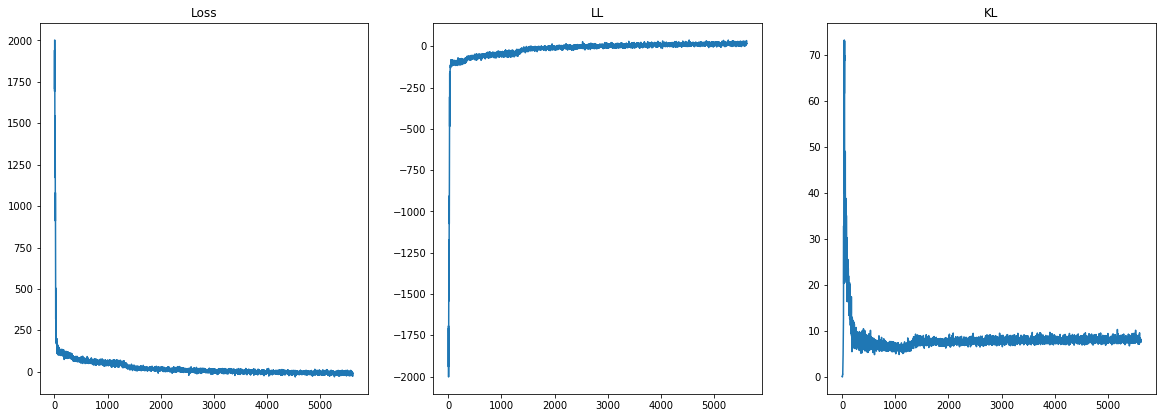

In [24]:
plot_learning_history(train_logs[0], train_logs[1], train_logs[2])

In [25]:
np.array(train_logs[-1])

array([ 0.19522333,  0.11441521,  0.08260532, ...,  7.61766434,
        8.20737839,  7.71289682])

## Predictions

In [26]:
num_to_plot = 500
ind = np.random.randint(len(X_train), size=num_to_plot)


In [27]:
mu_recon, logvar_recon, mu, logvar = model.forward(convert_to_var(X_train[ind]))

In [28]:
mu_recon = mu_recon.data.cpu().numpy()
logvar_recon = logvar_recon.data.cpu().numpy()
mu = mu.data.cpu().numpy()
logvar = logvar.data.cpu().numpy()

In [29]:
mu_recon = np.mean(mu_recon, axis=1)
logvar_recon = np.mean(logvar_recon, axis=1)

In [60]:
anomalies = np.array([[0,4], [5,0], [15,15]])

In [61]:
anom_mu_recon, anom_logvar_recon, \
anom_mu, anom_logvar = model.forward(convert_to_var(anomalies))

In [62]:
anomalies_ll = log_likelihood(convert_to_var(anomalies),
                              anom_mu, anom_logvar, 1, reduce_mean=False)

In [63]:
anomalies_ll.data.cpu().numpy()

array([  -5595.25292969,  -37895.109375  , -100700.7734375 ], dtype=float32)

In [64]:
anom_mu_recon = anom_mu_recon.data.cpu().numpy()
anom_logvar_recon = anom_logvar_recon.data.cpu().numpy()
anom_mu = anom_mu.data.cpu().numpy()
anom_logvar = anom_logvar.data.cpu().numpy()

In [65]:
anom_mu_recon = np.mean(anom_mu_recon, axis=1)
anom_logvar_recon = np.mean(anom_logvar_recon, axis=1)

In [66]:
colors = ['orange', 'green', 'blue']

In [51]:
def plot_point_with_std(mu, std, anom_mu, anom_std,
                        y_train, xlim, ylim, title):
    fig = plt.figure(figsize=(8,6))#plt.figure(0)
    ax = fig.add_subplot(111, aspect='equal')

    for i in range(len(mu)):
        e = Ellipse(mu[i], 6*std[i][0], 6*std[i][1])
        e.set_alpha(0.15)
        e.set_facecolor('gray')
        ax.add_artist(e)

        plt.plot(mu[i][0], mu[i][1], '.', markersize=5,
                 color=colors[int(y_train[i])], alpha=0.8)
        
    for i in range(len(anomalies)):
        e = Ellipse(anom_mu[i], 6*anom_std[i][0], 6*anom_std[i][1])
        e.set_alpha(0.1)
        e.set_facecolor('red')
        e.set_edgecolor('black')
        ax.add_artist(e)

        plt.plot(anom_mu[i][0], anom_mu[i][1], '.', markersize=6,
                 color='red', alpha=1)
        if title == 'Reconstruction':
            plt.plot(anomalies[i][0], anomalies[i][1], '.', markersize=10,
                     color='black', alpha=1)

        
    plt.grid()
    plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)

In [52]:
y_train = y_train.reshape(-1)

In [53]:
anomalies

array([[ 0,  4],
       [10,  0],
       [15, 15]])

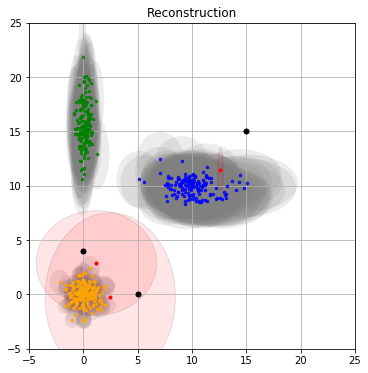

In [67]:
plot_point_with_std(mu_recon, np.exp(0.5*logvar_recon),
                    anom_mu_recon, anom_logvar_recon,
                    y_train[ind],
                    xlim=(-5, 25), ylim=(-5, 25),
                    title='Reconstruction')

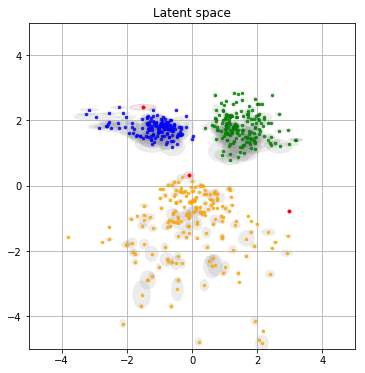

In [68]:
plot_point_with_std(mu, np.exp(0.5*logvar),
                    anom_mu, np.exp(0.5*anom_logvar), 
                    y_train[ind],
                    xlim=(-5, 5), ylim=(-5, 5),
                    title='Latent space')